##데이터 불러오기

In [192]:
import pandas as pd
import numpy as np
import seaborn as sns

df_origin = pd.read_csv("https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv")
df = df_origin
df.head()

,Unnamed: 0,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


In [193]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import matplotlib as mpl

# 폰트 변환
# Windows
# mpl.rc("font", family='Malgun Gothic')

# MacOS
mpl.rc("font", family='AppleGothic')

# 마이너스 사인 수정
mpl.rc('axes', unicode_minus=False)

warnings.filterwarnings("ignore")
%matplotlib inline

# 첫번째 방법
%config InlineBackend.figure_format='retina'

# 두번째 방법
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('retina')

# 둘 중 편한걸로 사용

## EDA

#### 데이터 타입 확인 및 변경

In [194]:
#데이터 확인
df.info()

#sales 값 object에서 float으로 타입 변경
df['NA_Sales'] = pd.to_numeric(df['NA_Sales'],errors = 'coerce') #coerce = 오류값 nan값으로 대체
df['EU_Sales'] = pd.to_numeric(df['EU_Sales'],errors = 'coerce')
df['JP_Sales'] = pd.to_numeric(df['JP_Sales'],errors = 'coerce')
df['Other_Sales'] = pd.to_numeric(df['Other_Sales'],errors = 'coerce')

#Total_sales 칼럼을 새로 만든다.
df['Total_sales'] = df['NA_Sales'] + df['EU_Sales'] + df['JP_Sales'] + df['Other_Sales']

#Total_sales가 0인 행 확인
condition = df["Total_sales"]<=0
print("Total_sales가 0인 행\n",df[condition].count(),"\n")
print("Sales 0값 제거 전 데이터:", df.shape)

#Total Sales가 0인 데이터도 삭제
df.drop(df.loc[df["Total_sales"] == 0].index, inplace = True) 
print("Sales 0값 제거 후 데이터:",df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   16598 non-null  int64  
 1   Name         16598 non-null  object 
 2   Platform     16598 non-null  object 
 3   Year         16327 non-null  float64
 4   Genre        16548 non-null  object 
 5   Publisher    16540 non-null  object 
 6   NA_Sales     16598 non-null  object 
 7   EU_Sales     16598 non-null  object 
 8   JP_Sales     16598 non-null  object 
 9   Other_Sales  16598 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 1.3+ MB
Total_sales가 0인 행
 Unnamed: 0     1
Name           1
Platform       1
Year           1
Genre          1
Publisher      1
NA_Sales       1
EU_Sales       1
JP_Sales       1
Other_Sales    1
Total_sales    1
dtype: int64 

Sales 0값 제거 전 데이터: (16598, 11)
Sales 0값 제거 후 데이터: (16597, 11)


#### 결측치 확인 및 제거

In [195]:
#결측치 확인
print("결측치:\n",df.isnull().sum(),"\n") 

print("결측치 제거 전 데이터:",df.shape)

df = df.drop(df.columns[[0]], axis=1) #첫번째 열 제거
df = df.dropna(axis = 0) #결측치가 포함된 모든 행 제거
df = df.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='') #인덱스 reset

print("결측치 제거 후 데이터:",df.shape)

결측치:
 Unnamed: 0       0
Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales       200
EU_Sales       200
JP_Sales       199
Other_Sales    200
Total_sales    785
dtype: int64 

결측치 제거 전 데이터: (16597, 11)
결측치 제거 후 데이터: (15475, 10)


#### 중복 데이터 값 확인 및 제거

In [196]:
#duplicated 게임이름 검색하여 확인
df.duplicated().sum()

#모든 값이 동일한 데이터가 없기 때문에 제거 대상 없음

0

##지역에 따라서 선호하는 게임 장르

NA_Sales: 11268
EU_Sales: 10139
JP_Sales: 5762
Other_Sales: 9475 

NA_Sales       4080.71
EU_Sales       2265.25
JP_Sales       1204.19
Other_Sales     748.17
dtype: float64


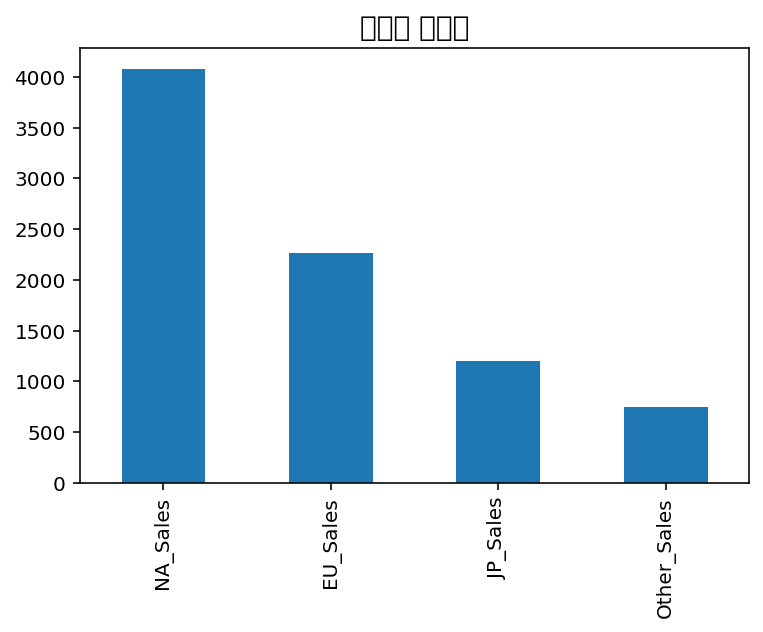

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_sales
Genre,,,,,,
Action,6178702.0,804.68,487.72,150.70,176.49,1619.59
Sports,4382122.0,636.44,351.05,126.83,126.73,1241.05
Shooter,2433267.0,546.92,294.28,37.19,97.07,975.46
Role-Playing,2777818.0,295.54,166.88,320.83,52.88,836.13
Platform,1621345.0,413.88,185.34,123.19,48.18,770.59


In [197]:
#지역별 sales값 확인
print("NA_Sales:",df[df["NA_Sales"] > 0].value_counts().sum())
print("EU_Sales:",df[df["EU_Sales"] > 0].value_counts().sum())
print("JP_Sales:",df[df["JP_Sales"] > 0].value_counts().sum())
print("Other_Sales:",df[df["Other_Sales"] > 0].value_counts().sum(),"\n")

df_hist_area = df[["NA_Sales","EU_Sales","JP_Sales","Other_Sales"]].sum()
print(df_hist_area)

df_hist_area.plot.bar()
plt.title('국가별 출고량',fontsize=14) ## 타이틀 출력
plt.show()


#지역별 국가가 선호하는 장르 순위(출고량 합산 값)
df.groupby(["Genre"],axis=0, sort = True).sum().sort_values(by = ["Total_sales"],ascending = False).head(5)

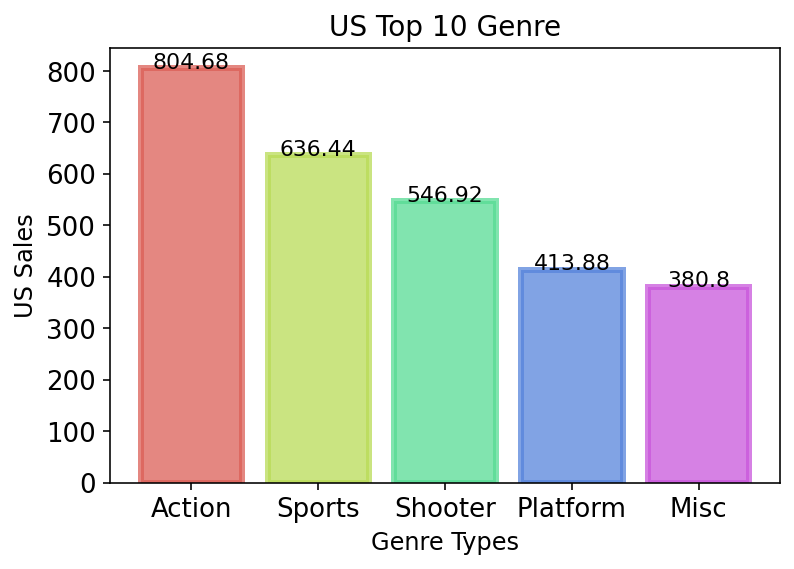

In [198]:
#미국이 선호하는 장르 순위(출고량 합산 값)
df_US = df.groupby(["Genre"],axis=0, sort = True).sum()["NA_Sales"].sort_values(ascending = False).head(5)

## 시각화
tick_size = 13 ## 눈금 폰트 사이즈
axis_label_size = 12 ## x축, y축 폰트 사이즈
 
fig = plt.figure(figsize=(6,4)) ## Figure 생성 사이즈는 10 by 10
ax = fig.add_subplot() ## Axes 추가
colors = sns.color_palette('hls',len(df_US)) ## 색상 지정
 
xtick_label_position = list(range(len(df_US))) ## x축 눈금 라벨이 표시될 x좌표
 
plt.yticks(fontsize=tick_size)
plt.xticks(xtick_label_position, df_US.index, fontsize=tick_size) ## x축 눈금 라벨 출력
 
bars = plt.bar(xtick_label_position, df_US, color=colors, \
               edgecolor=colors, alpha=0.75, linewidth=3) ## 바차트 출력
 
for i, b in enumerate(bars):
    ax.text(b.get_x()+b.get_width()*(1/2),b.get_height()+0.1, \
            df_US[i],ha='center',fontsize=11)
    
plt.title('US Top 10 Genre',fontsize=14) ## 타이틀 출력
plt.xlabel('Genre Types',fontsize=axis_label_size) ## x축 라벨 출력
plt.ylabel('US Sales',fontsize=axis_label_size) ## y축 라벨 출력
plt.show()

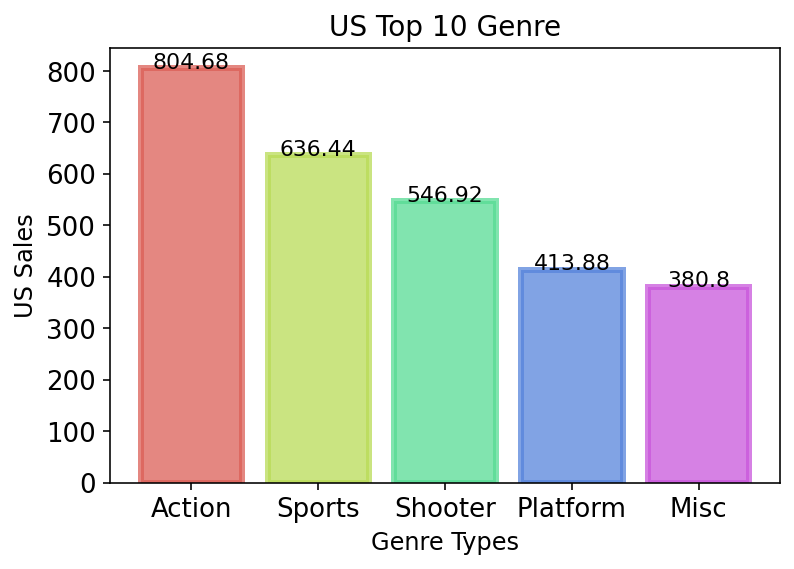

In [199]:
#유럽연합이 선호하는 장르 순위

df_EU = df.groupby(["Genre"],axis=0, sort = True).sum()["NA_Sales"].sort_values(ascending = False).head(5)

## 시각화
tick_size = 13 ## 눈금 폰트 사이즈
axis_label_size = 12 ## x축, y축 폰트 사이즈
 
fig = plt.figure(figsize=(6,4)) ## Figure 생성 사이즈는 10 by 10
ax = fig.add_subplot() ## Axes 추가
colors = sns.color_palette('hls',len(df_US)) ## 색상 지정
 
xtick_label_position = list(range(len(df_US))) ## x축 눈금 라벨이 표시될 x좌표
 
plt.yticks(fontsize=tick_size)
plt.xticks(xtick_label_position, df_US.index, fontsize=tick_size) ## x축 눈금 라벨 출력
 
bars = plt.bar(xtick_label_position, df_US, color=colors, \
               edgecolor=colors, alpha=0.75, linewidth=3) ## 바차트 출력
 
for i, b in enumerate(bars):
    ax.text(b.get_x()+b.get_width()*(1/2),b.get_height()+0.1, \
            df_US[i],ha='center',fontsize=11)
    
plt.title('US Top 10 Genre',fontsize=14) ## 타이틀 출력
plt.xlabel('Genre Types',fontsize=axis_label_size) ## x축 라벨 출력
plt.ylabel('US Sales',fontsize=axis_label_size) ## y축 라벨 출력
plt.show()

##연도별 게임의 트렌드가 있을까

##출고량이 높은 게임에 대한 분석 및 시각화 프로세스

In [200]:
#플렛폼별 게임 갯수 top10
print("플렛폼별 게임 카운트 top10")
print(df['Platform'].value_counts().head(10),"\n")

#플렛폼 별 토탈 게임 출고량 순 top10
print("플렛폼 별 토탈 게임 출고량 순 top10")
print(df.groupby(['Platform']).sum()["Total_sales"].sort_values(ascending = False).head(10))

플렛폼별 게임 카운트 top10
DS      2035
PS2     2024
PS3     1234
Wii     1222
X360    1176
PSP     1137
PS      1121
PC       890
XB       762
GBA      747
Name: Platform, dtype: int64 

플렛폼 별 토탈 게임 출고량 순 top10
Platform
PS2     1172.40
PS3      901.61
X360     895.40
Wii      868.18
DS       787.69
PS       681.18
PSP      282.93
GBA      279.30
PS4      252.97
PC       243.04
Name: Total_sales, dtype: float64


In [201]:
df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0.00,0.00,0.00,0.04
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0.00,0.00,0.01,0.18
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25
...,...,...,...,...,...,...,...,...,...,...
15470,Ice Age 2: The Meltdown,GC,2006.0,Platform,Vivendi Games,0.15,0.04,0.00,0.01,0.20
15471,Rainbow Islands: Revolution,PSP,2005.0,Action,Rising Star Games,0.01,0.00,0.00,0.00,0.01
15472,NBA 2K16,PS3,2015.0,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13,0.79
15473,Toukiden: The Age of Demons,PSV,2013.0,Action,Tecmo Koei,0.05,0.05,0.25,0.03,0.38
